In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,make_scorer, accuracy_score, f1_score, recall_score, classification_report
import seaborn as sns
from sklearn.model_selection import GridSearchCV,KFold
import warnings

# Désactiver tous les avertissements
warnings.filterwarnings('ignore')

# Ou désactiver uniquement les avertissements de type FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)


In [2]:
df = pd.read_csv('dataset.csv')
df['NewExist'] = df['NewExist'].fillna(0)

In [30]:
df.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv',
       'cat_activites', 'SBA_loan_float', 'bank_loan_float', 'crisis'],
      dtype='object')

In [103]:


features_of_interest = ['State','NAICS', 'UrbanRural','LowDoc','bank_loan_float','SBA_loan_float','FranchiseCode','BankState','Bank','RevLineCr','Term','crisis',
    'MIS_Status'
]

numerical_column = ['bank_loan_float','SBA_loan_float','Term'
    
]


ordinal_column = [
    'LowDoc', 'UrbanRural','crisis'
]

categorical_column = [
    'State','NAICS','FranchiseCode','BankState','RevLineCr','Bank',
]


target_name = "MIS_Status"
data, target, numerical_data, ordinal_data, categorical_data = (
    df[features_of_interest],
    df[target_name],
    df[numerical_column],
    df[ordinal_column],
    df[categorical_column]
)

In [104]:
X_train, X_test, y_train, y_test = train_test_split(data, target,train_size=0.9, random_state=42, stratify=data['MIS_Status'])
# Retirer la colonne 'MIS_Status' des ensembles X_train et X_test (pour éviter le data leaking)
X_train = X_train.drop('MIS_Status', axis=1)
X_test = X_test.drop('MIS_Status', axis=1)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [105]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", RobustScaler(), numerical_column),
    ],
    remainder="passthrough",
)

In [106]:


clf = make_pipeline(preprocessor,lgb.LGBMClassifier(n_estimators=192, max_depth=16,learning_rate=0.2778500645478852, subsample=0.9022562944848265)) 
# clf = make_pipeline(preprocessor,lgb.LGBMClassifier(n_estimators=100, max_depth=13,learning_rate=0.6, subsample=0.9022562944848265)) 
clf.fit(X_train, y_train_encoded)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'NAICS',
                                                   'FranchiseCode', 'BankState',
                                                   'RevLineCr', 'Bank']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['LowDoc', 'UrbanRural',
                                                   'crisis']),
                                                 ('numeric', RobustScaler(),
                                                  ['bank_loan_float',
                                                   'SBA_loan_float',
                                                   'Term'])])),
                ('lgbmclassifier',
                 LGBMClassifier(learning_rate=0.2778500645478852, max_depth=16,
                                n_estimators=192,
                                subsample=0.9022562944848265))])

In [107]:
# Si c'est un problème binaire, prenez la probabilité pour la classe 1 (classe positive)
proba = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)
# Calcul du score AUC-ROC
roc_auc = roc_auc_score(y_test_encoded, proba)
print("AUC-ROC score:", roc_auc)
print('accuracy', clf.score(X_test,y_test_encoded))
print('rappel', recall_score(y_test_encoded,y_pred,pos_label=0))
print('f1_score',f1_score(y_test_encoded,y_pred, pos_label=0))
print(classification_report(y_test_encoded,y_pred))

AUC-ROC score: 0.9798503958855266
accuracy 0.9509547693984453
rappel 0.8294259282727158
f1_score 0.8558352402745996
              precision    recall  f1-score   support

           0       0.88      0.83      0.86     15782
           1       0.96      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.92      0.90      0.91     89917
weighted avg       0.95      0.95      0.95     89917



In [108]:
#Dataframe pour les features of importances

df_rf = pd.DataFrame(clf[-1].feature_importances_,clf[0].get_feature_names_out())
df_rf=df_rf.transpose()
df_rf.columns

Index(['categorical__State_AK', 'categorical__State_AL',
       'categorical__State_AP', 'categorical__State_AR',
       'categorical__State_AZ', 'categorical__State_CA',
       'categorical__State_CO', 'categorical__State_CT',
       'categorical__State_DC', 'categorical__State_DE',
       ...
       'categorical__Bank_ZAPATA NATIONAL BANK',
       'categorical__Bank_ZAVALA COUNTY BANK',
       'categorical__Bank_ZIONS FIRST NATIONAL BANK', 'categorical__Bank_nan',
       'ordinal__LowDoc', 'ordinal__UrbanRural', 'ordinal__crisis',
       'numeric__bank_loan_float', 'numeric__SBA_loan_float', 'numeric__Term'],
      dtype='object', length=9812)

In [ ]:
plot_tree

In [109]:
# Création des sommes pour les features importances pour chaque variable catégorielle


liste_sum = []
for column in data.columns:
    sum_column = 0


    for elem in df_rf:
       if column in elem:
           sum_column += df_rf[elem]

    df_rf[f'sum_{column}'] = sum_column
    liste_sum.append(f'sum_{column}')
print(liste_sum)
    


['sum_State', 'sum_NAICS', 'sum_UrbanRural', 'sum_LowDoc', 'sum_bank_loan_float', 'sum_SBA_loan_float', 'sum_FranchiseCode', 'sum_BankState', 'sum_Bank', 'sum_RevLineCr', 'sum_Term', 'sum_crisis', 'sum_MIS_Status']


In [110]:
df_rf_graphique = df_rf[liste_sum]

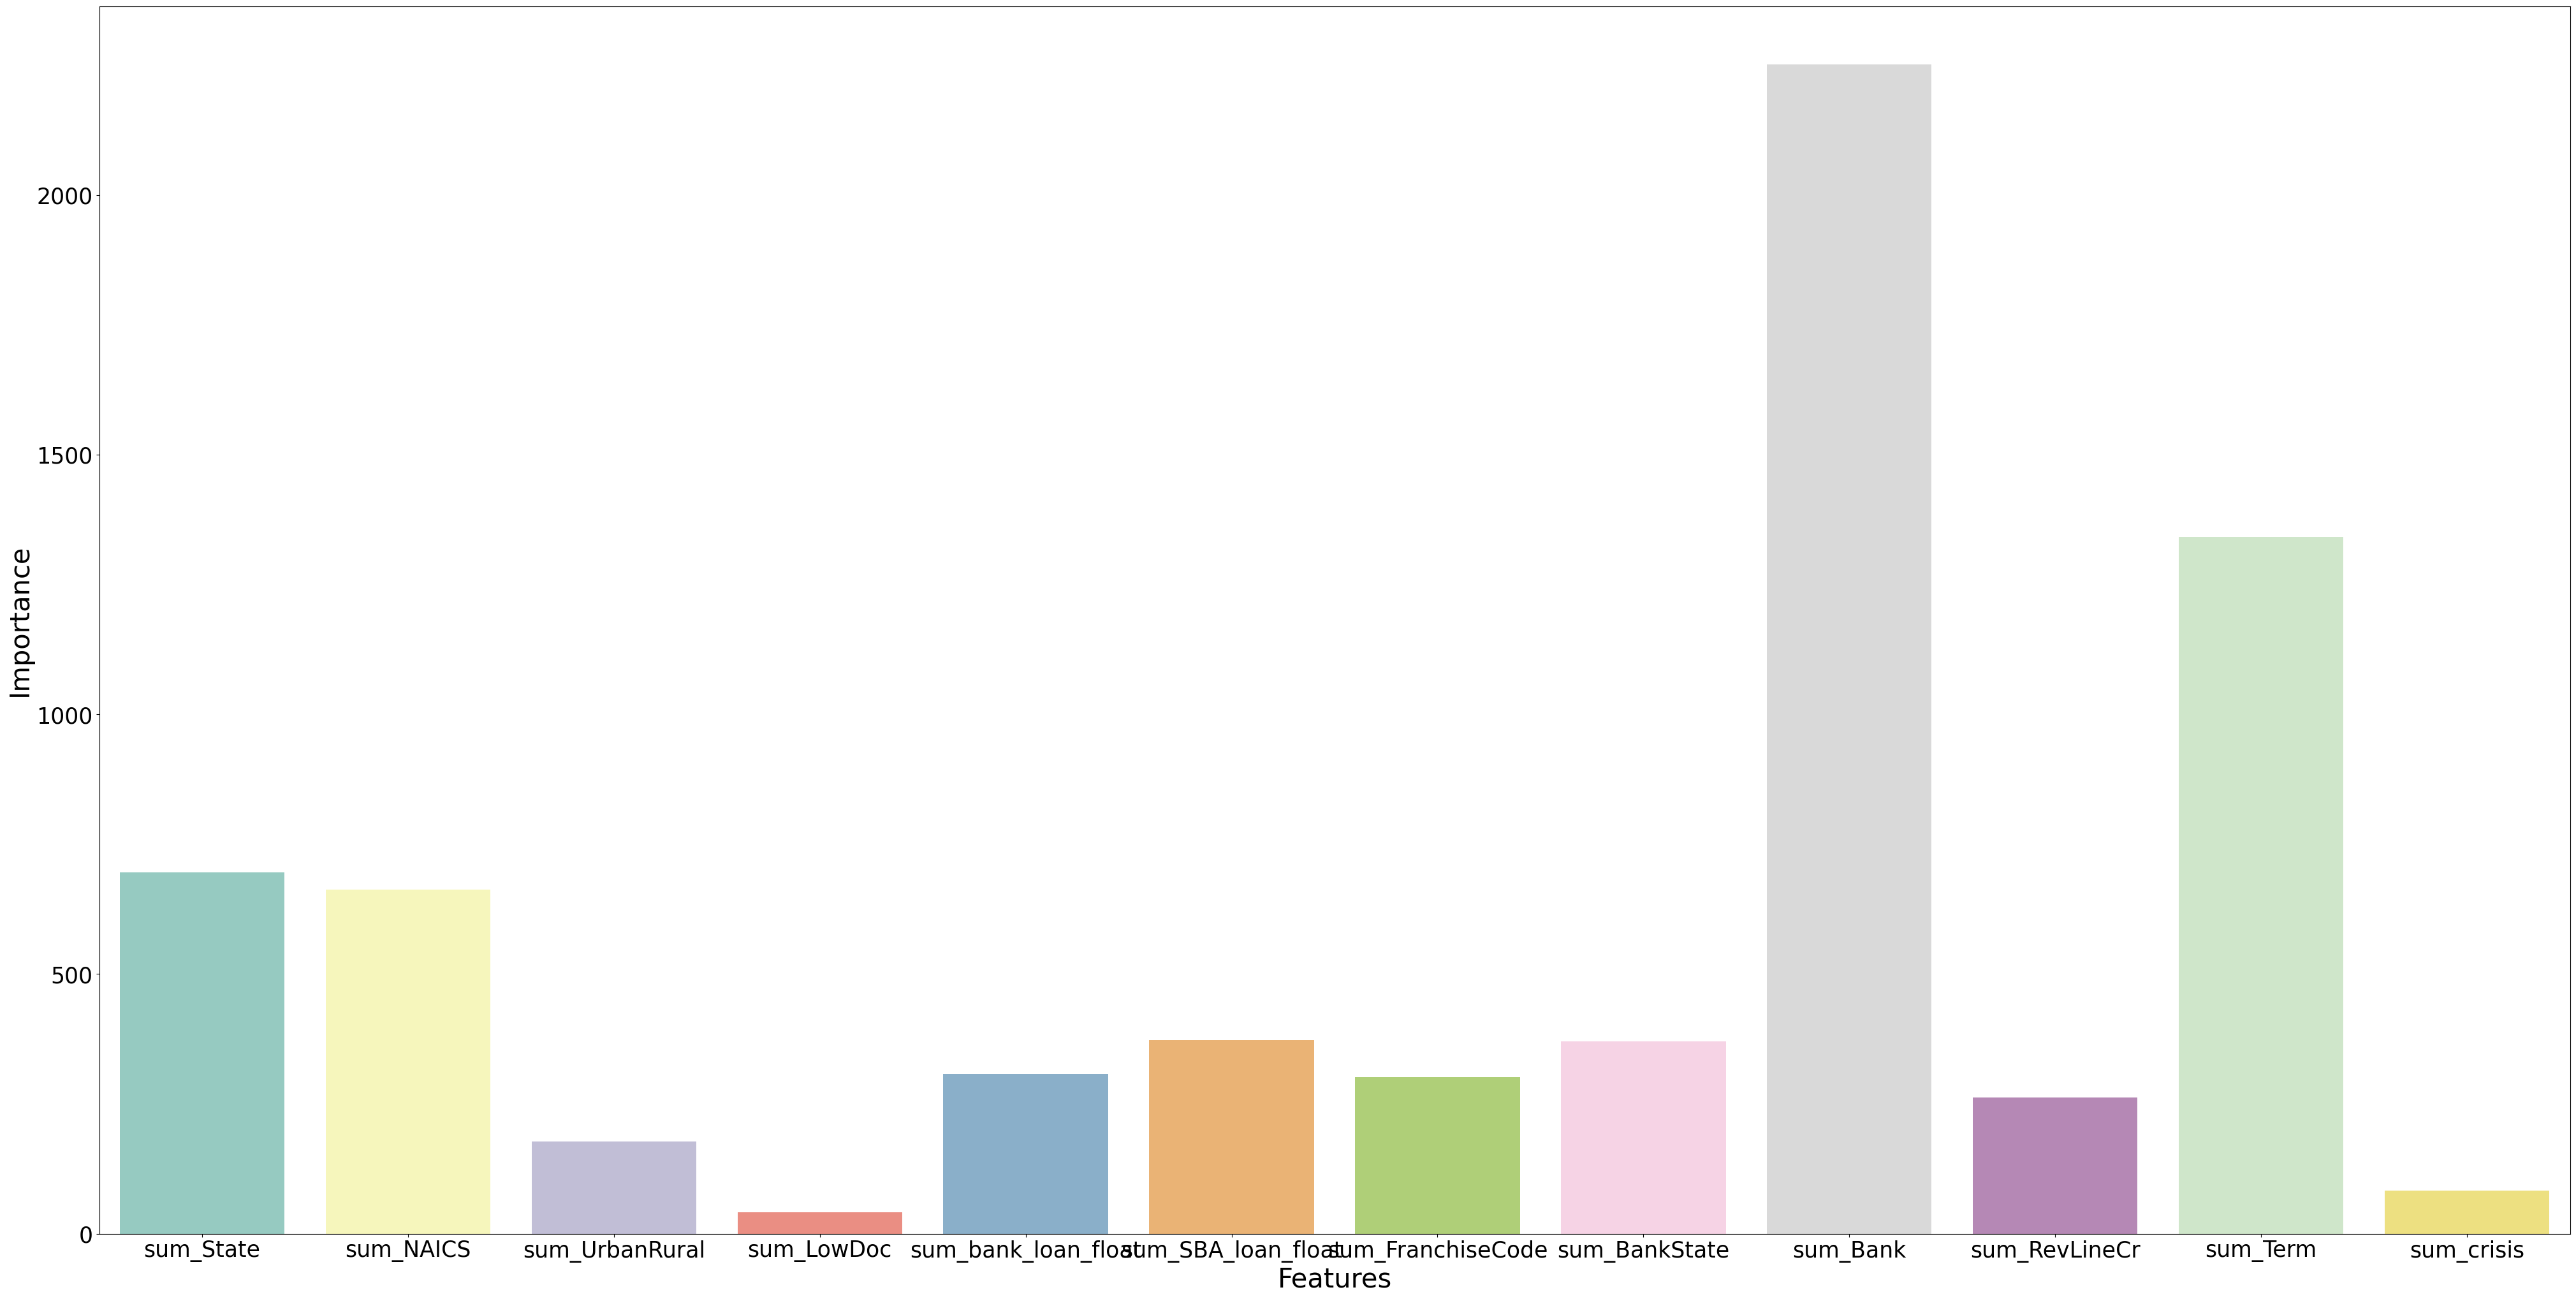

In [111]:


plt.figure(figsize=(50, 25))
sns.barplot(data=df_rf_graphique.drop('sum_MIS_Status', axis = 1), palette="Set3")

# Augmenter la taille des labels des axes
plt.xlabel("Features", fontsize=30)
plt.ylabel("Importance", fontsize=30)

# Augmenter la taille des ticks des axes
plt.tick_params(axis='both', labelsize=25)
plt.show()

In [34]:
y_pred = clf.predict(X_test)
y_pred

array([1, 0, 1, ..., 1, 1, 1])

In [35]:
# import pickle
# pickle.dump(clf,open('clf_lgbm.pkl','wb'))
X_train

,State,cat_activites,UrbanRural,LowDoc,bank_loan_float,SBA_loan_float,FranchiseCode,BankState,RevLineCr,Term,ApprovalFY,crisis
769904,IL,45,0,Y,100000.0,90000.0,36560,IL,NaN,60,1995,0
653567,DC,56,0,N,5000.0,4250.0,1,CA,0,1,2003,0
426296,CA,23,1,N,400000.0,300000.0,1,CA,N,120,2001,1
330866,NY,54,1,N,10000.0,5000.0,0,NY,Y,36,2009,0
745739,CA,31,0,N,300000.0,210000.0,1,CA,N,84,1995,0
...,...,...,...,...,...,...,...,...,...,...,...,...
827911,OH,42,2,N,75000.0,37500.0,1,OH,Y,84,2005,0
248832,NY,44,1,N,70000.0,35000.0,0,NY,Y,8,2008,1
730785,IN,54,0,Y,50000.0,45000.0,1,IN,N,84,1994,0
480600,IN,44,0,N,145000.0,145000.0,1,IN,N,240,1992,0


In [23]:
import optuna

def objective(trial):
    # Définir les hyperparamètres à optimiser
    # n_estimators = trial.suggest_int('n_estimators', 150, 200)
    # max_depth = trial.suggest_int('max_depth', 6, 16)
    # learning_rate = trial.suggest_float('learning_rate', 0.3, 0.6, log=True)
    # l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 11, 20)
    # subsample = trial.suggest_float('subsample', 0.3, 1)

    n_estimators = trial.suggest_int('n_estimators', 0, 200)
    max_depth = trial.suggest_int('max_depth', 4, 16)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 10)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    
    # Créer le modèle de classification avec les hyperparamètres choisis
    xgboost = make_pipeline(
        preprocessor, 
        lgb.LGBMClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
        )
    ) 
    
    # Entraîner le modèle
    xgboost.fit(X_train, y_train_encoded)
    
    # Prédire sur le jeu de test et calculer l'accuracy
    y_pred = xgboost.predict(X_test)
    proba = xgboost.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test_encoded, proba)
    
    return roc_auc

# Créer et lancer l'étude Optuna
study = optuna.create_study(direction='maximize')  # Maximiser l'accuracy
study.optimize(objective, n_trials=100)# Essayer 10 différentes combinaisons d'hyperparamètres



# Afficher les meilleurs hyperparamètres et le meilleur score
print('Meilleurs hyperparamètres :', study.best_params)
print('Meilleur score d\'accuracy :', study.best_value)

[I 2025-02-12 14:28:30,733] A new study created in memory with name: no-name-e82bfbf7-eb36-4f78-a89b-612b1584c754
[I 2025-02-12 14:28:36,211] Trial 0 finished with value: 0.9637136321457214 and parameters: {'n_estimators': 70, 'max_depth': 6, 'learning_rate': 0.029566991506077275, 'l2_leaf_reg': 4.417955111084149, 'subsample': 0.8437016779859567}. Best is trial 0 with value: 0.9637136321457214.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-12 14:28:41,501] Trial 1 finished with value: 0.9775392922061434 and parameters: {'n_estimators': 89, 'max_depth': 6, 'learning_rate': 0.1593379895448879, 'l2_leaf_reg': 4.107820059262819, 'subsample': 0.9659469388717605}. Best is trial 1 with value: 0.9775392922061434.
[I 2025-02-12 14:28:45,916] Trial 2 finished with value: 0.9754578700040633 and parameters: {'n_estimators': 36, 'max_depth': 16, 'learning_rate': 0.14735199830401055, 'l2_leaf_reg': 2.646539377248796, 'subsample': 0.892701574770137}. Best is trial 1 with value: 0.9775392922061434.
[I 2025-02-12 14:28:55,396] Trial 3 finished with value: 0.9817547353925399 and parameters: {'n_estimators': 184, 'max_depth': 12, 'learning_rate': 0.15873494071684888, 'l2_leaf_reg': 8.637022475668308, 'subsample': 0.9806046982467449}. Best is trial 3 with value: 0.9817547353925399.
[I 2025-02-12 14:29:01,154] Trial 4 finished with value: 0.9622609030197363 and parameters: {'n_estimators': 64, 'max_depth': 12, 'learning_rate': 0.0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-12 14:29:07,430] Trial 5 finished with value: 0.9790010734799445 and parameters: {'n_estimators': 111, 'max_depth': 6, 'learning_rate': 0.17434394807098502, 'l2_leaf_reg': 8.539364360372804, 'subsample': 0.9135335207822974}. Best is trial 3 with value: 0.9817547353925399.
[I 2025-02-12 14:29:14,376] Trial 6 finished with value: 0.9791566052939706 and parameters: {'n_estimators': 118, 'max_depth': 7, 'learning_rate': 0.14634735550549377, 'l2_leaf_reg': 1.7880276393272754, 'subsample': 0.6385146822509785}. Best is trial 3 with value: 0.9817547353925399.
[I 2025-02-12 14:29:22,608] Trial 7 finished with value: 0.9815373005114016 and parameters: {'n_estimators': 134, 'max_depth': 16, 'learning_rate': 0.164618446282313, 'l2_leaf_reg': 3.868176645070507, 'subsample': 0.6097150623720278}. Best is trial 3 with value: 0.9817547353925399.
[I 2025-02-12 14:29:28,001] Trial 8 finished with value: 0.9752819091052393 and parameters: {'n_estimators': 73, 'max_depth': 6, 'learning_rate': 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-12 14:30:44,332] Trial 18 finished with value: 0.9695312704527492 and parameters: {'n_estimators': 137, 'max_depth': 4, 'learning_rate': 0.056841827215683295, 'l2_leaf_reg': 9.772212763473478, 'subsample': 0.7542524008812218}. Best is trial 11 with value: 0.9828117379664831.
[I 2025-02-12 14:30:52,977] Trial 19 finished with value: 0.9826580040179024 and parameters: {'n_estimators': 177, 'max_depth': 15, 'learning_rate': 0.22959228390627998, 'l2_leaf_reg': 7.686815430318063, 'subsample': 0.8635468643825541}. Best is trial 11 with value: 0.9828117379664831.
[I 2025-02-12 14:31:00,823] Trial 20 finished with value: 0.9789762841334071 and parameters: {'n_estimators': 134, 'max_depth': 10, 'learning_rate': 0.09086913982475593, 'l2_leaf_reg': 6.617049791946651, 'subsample': 0.7979122333359415}. Best is trial 11 with value: 0.9828117379664831.
[I 2025-02-12 14:31:08,783] Trial 21 finished with value: 0.9823812870130259 and parameters: {'n_estimators': 173, 'max_depth': 15, 'learni

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-12 14:35:54,373] Trial 53 finished with value: 0.9797080427200864 and parameters: {'n_estimators': 199, 'max_depth': 4, 'learning_rate': 0.26229134307574664, 'l2_leaf_reg': 3.373774622664106, 'subsample': 0.6161704934940188}. Best is trial 11 with value: 0.9828117379664831.
[I 2025-02-12 14:36:02,634] Trial 54 finished with value: 0.982402955842929 and parameters: {'n_estimators': 166, 'max_depth': 15, 'learning_rate': 0.1939984136017794, 'l2_leaf_reg': 8.098130473342769, 'subsample': 0.641382456874571}. Best is trial 11 with value: 0.9828117379664831.
[I 2025-02-12 14:36:10,070] Trial 55 finished with value: 0.9818731821185046 and parameters: {'n_estimators': 158, 'max_depth': 14, 'learning_rate': 0.22617497460738992, 'l2_leaf_reg': 5.481159630718074, 'subsample': 0.6946910516546517}. Best is trial 11 with value: 0.9828117379664831.
[I 2025-02-12 14:36:15,382] Trial 56 finished with value: 0.9779473311663962 and parameters: {'n_estimators': 63, 'max_depth': 16, 'learning_ra

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-12 14:36:31,546] Trial 58 finished with value: 0.9808954715218156 and parameters: {'n_estimators': 168, 'max_depth': 5, 'learning_rate': 0.28067260196010685, 'l2_leaf_reg': 1.6323412432434485, 'subsample': 0.6743689906149551}. Best is trial 11 with value: 0.9828117379664831.
[I 2025-02-12 14:36:42,296] Trial 59 finished with value: 0.9743947999013366 and parameters: {'n_estimators': 192, 'max_depth': 13, 'learning_rate': 0.023534289612789323, 'l2_leaf_reg': 2.32524955241494, 'subsample': 0.7781392250768291}. Best is trial 11 with value: 0.9828117379664831.
[I 2025-02-12 14:36:50,701] Trial 60 finished with value: 0.9819357488616417 and parameters: {'n_estimators': 152, 'max_depth': 14, 'learning_rate': 0.17778358012536316, 'l2_leaf_reg': 7.385992093456042, 'subsample': 0.7424336434668125}. Best is trial 11 with value: 0.9828117379664831.
[I 2025-02-12 14:37:00,248] Trial 61 finished with value: 0.9825845774324322 and parameters: {'n_estimators': 180, 'max_depth': 15, 'learni

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-12 14:38:19,815] Trial 70 finished with value: 0.9811177931610634 and parameters: {'n_estimators': 187, 'max_depth': 7, 'learning_rate': 0.16204196474390914, 'l2_leaf_reg': 3.6101157884626547, 'subsample': 0.6196905662783855}. Best is trial 11 with value: 0.9828117379664831.
[I 2025-02-12 14:38:31,294] Trial 71 finished with value: 0.9826996382568228 and parameters: {'n_estimators': 180, 'max_depth': 15, 'learning_rate': 0.2655821968351695, 'l2_leaf_reg': 1.9425919598180226, 'subsample': 0.6618327467677833}. Best is trial 11 with value: 0.9828117379664831.
[I 2025-02-12 14:38:34,551] Trial 72 finished with value: 0.9527124127168807 and parameters: {'n_estimators': 3, 'max_depth': 15, 'learning_rate': 0.2649100753315254, 'l2_leaf_reg': 2.7098268636332787, 'subsample': 0.6345579874475775}. Best is trial 11 with value: 0.9828117379664831.
[I 2025-02-12 14:38:42,347] Trial 73 finished with value: 0.9821960880687232 and parameters: {'n_estimators': 172, 'max_depth': 14, 'learning

Meilleurs hyperparamètres : {'n_estimators': 192, 'max_depth': 16, 'learning_rate': 0.2778500645478852, 'l2_leaf_reg': 8.816363318952076, 'subsample': 0.9022562944848265}
Meilleur score d'accuracy : 0.9830225741216078
